<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/nin2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Network in Network**

# **Section 1. Set up**

In [1]:
!pip install einops
!pip install scipy==1.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### *Dataset and DataLoader*


How to normalize CIFAR-10: [link](https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py).

In [3]:
from torch.utils.data import Dataset, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize

cifar10 = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
data_means = (cifar10.data / 255.0).mean(axis=(0,1,2))
data_std = (cifar10.data / 255.0).std(axis=(0,1,2))
print("Data mean", data_means)
print("Data std", data_std)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [4]:
from einops import rearrange
from numpy.linalg import eig
from scipy.sparse import dia_array

mean = cifar10.data.mean(axis=0)
images = (cifar10.data - mean) / 255.0
images = rearrange(images, 'N H W C -> N (H W C)')
cov = np.cov(images, rowvar=False)
L, V = eig(cov)
print(L.shape)
print(V.shape)

# def zca_matrix(self):
#   n = len(self.targets)
#   images = (self.data - self.mean) / 255.0    
#   images = rearrange(images, 'N H W C -> N (H W C)')
#   cov = np.cov(images,  rowvar=False)
#   L, V = eig(cov)
#   W = V @  np.diag(L**(-0.5)) @ V.T
#   return W



(3072,)
(3072, 3072)


In [13]:
K = dia_array((L, 0), shape=(3072, 3072))
K2 = V @ K

In [ ]:
K2 @ V.T

In [ ]:
W = V @  np.diag(L**(-0.5)) @ V.T

In [4]:
from torch.utils.data import Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage
from einops import rearrange
from numpy.linalg import eig

class CIFAR10Dataset(Dataset):
  def __init__(self, root="./data", train=False, download=True, index=None):
    
    cifar10 = CIFAR10(root, train, download=download)

    if index is None:
      self.data, self.targets  = cifar10.data, cifar10.targets
    else:
      self.data = cifar10.data[index]
      self.targets = [cifar10.targets[i] for i in index]

    self.mean = self.data.mean(axis=0)
    self.W = self.zca_matrix() 


  def __len__(self):
    return len(self.cifar10)


  def __getitem__(self, idx):
    image, label = self.data[idx], self.targets[idx]
    image = image - self.mean           # normalization
    image = self.whiten(image)          # zca-whitening
    return ToTensor(image), label


  def zca_matrix(self):
    n = len(self.targets)
    images = (self.data - self.mean) / 255.0    
    images = rearrange(images, 'N C H W -> N (C H W)')
    cov = np.cov(images,  rowvar=False)
    L, V = eig(cov)
    W = V @  np.diag(L**(-0.5)) @ V.T
    return W

  def whiten(self, image):
    images = images / 255.0
    images = rearrange(images, 'N C H W -> N (C H W)')
    whiten_image = (image / 255.0) @ self.W
    whiten_image = rearrange(whiten_image, 'N (C H W) -> N C H W')
    return whiten_image

[ZCA1](https://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening)
[ZCA2](https://towardsdatascience.com/pca-whitening-vs-zca-whitening-a-numpy-2d-visual-518b32033edf#:~:text=ZCA%2Dwhitening%20is%20done%20by,possible%20from%20the%20original%20data.)

In [6]:
# Generate indices to permute the training data and conduct train-test-split
total_size = 50000
valid_size = total_size // 10
rng = np.random.default_rng(42)
indices = rng.permutation(total_size)

train_dataset = CIFAR10Dataset(
    train = True,
    index = indices[0:5]
)

valid_dataset = CIFAR10Dataset(
    train = True, 
    index = indices[5:10]
)

# test_dataset = CIFAR10Dataset(train=False, index=index[0:5])


print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)

Files already downloaded and verified
Files already downloaded and verified


NameError: ignored

In [7]:
import matplotlib.pyplot as plt

# Raw Images
n_view = 3
sample_images = [train_dataset[i][0] for i in range(n_view)]
sample_targets = [train_dataset[i][1] for i in range(n_view)]
s = ToPILImage()(torch.dstack(sample_images))
print(sample_targets)

image_shape = tuple(sample_images[0].shape)
print("\nImage shape:", image_shape)


plt.figure(figsize=(8,8))
plt.imshow(s)
plt.axis('off')
plt.show()
plt.close()

AttributeError: ignored

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

### *Network Architecture*

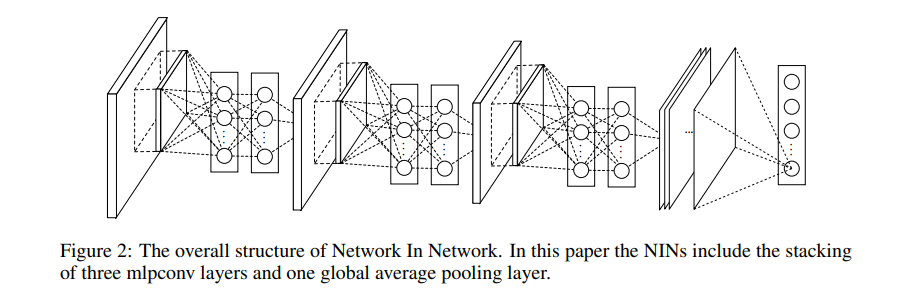

The network architecture is built based on this [prototext](https://gist.github.com/mavenlin/e56253735ef32c3c296d) from the Caffe model zoo. Note one should set `MaxPool2d(ceil_mode=True)` to get the correct dimension.


In [ ]:
from torch.nn import (
    Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout, Sequential, Flatten
)


def CCCP(in_channels, out_channels):
  return Conv2d(in_channels, out_channels, kernel_size=1)

def MlpConv(in_channels, hidden_channels, out_channels, kernel_size, stride=1, padding=0):
  return nn.Sequential(
      Conv2d(in_channels, hidden_channels[0], kernel_size, stride, padding),
      ReLU(),
      CCCP(hidden_channels[0], hidden_channels[1]),
      ReLU(),
      CCCP(hidden_channels[1], out_channels),
      ReLU()
  )

class NiN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = Sequential(
        MlpConv(3, (192, 160), 96, kernel_size=5, padding=2),
        MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(96, (192, 192), 192, kernel_size=5, padding=2),
        AvgPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(192, (192, 192), num_classes, kernel_size=3, padding=1),
        AvgPool2d(kernel_size=8, stride=1),
        Flatten()
    )

    # Remember to initialize the weights and biases.
    # Default initialization from pytorch doesn't work well.
    self.net.apply(self.init_weights)

  def forward(self, x):
    return self.net(x)

  @staticmethod
  def init_weights(m):
    if isinstance(m, Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.05)
        torch.nn.init.zeros_(m.bias)

print(NiN())

NiN(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Sequential(
      (0): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (4): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (3)

In [ ]:
# Check forward path
X = torch.randn(1, *image_shape)
print(f"{'Image shape:':25s} {list(X.shape)}")
for layer in NiN().net:
    X=layer(X)
    print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")

Image shape:              [1, 3, 32, 32]
Sequential output shape:  [1, 96, 32, 32]
MaxPool2d output shape:   [1, 96, 16, 16]
Dropout output shape:     [1, 96, 16, 16]
Sequential output shape:  [1, 192, 16, 16]
AvgPool2d output shape:   [1, 192, 8, 8]
Dropout output shape:     [1, 192, 8, 8]
Sequential output shape:  [1, 10, 8, 8]
AvgPool2d output shape:   [1, 10, 1, 1]
Flatten output shape:     [1, 10]


### *Validation Step*

In [ ]:
def validate(model, dataloader, device=torch.device('cuda')):
  model.eval()
  acc = []

  with torch.no_grad():
    for images, targets in dataloader:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      pred_labels = torch.argmax(preds, dim=1)
      acc.append((pred_labels == targets).type(torch.float32).mean().item())
  
  return acc

### *Testing Step*

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def test(model, dataloader, class_names=None, device=torch.device('cuda')):
  model.eval()
  np_pred_labels = []
  np_targets = []

  # Obtain predictions and ground truths
  with torch.no_grad():
      for images, targets in test_dataloader:
          images, targets = images.to(device), targets.to(device)
          preds = test_model(images)
          pred_labels = torch.argmax(preds, dim=1)
          
          pred_labels = pred_labels.view(-1).detach().cpu().numpy()
          targets = targets.view(-1).detach().cpu().numpy()

          np_pred_labels.append(pred_labels)
          np_targets.append(targets)

  ## Calculate confusion matrix
  np_pred_labels = np.concatenate(np_pred_labels)
  np_targets = np.concatenate(np_targets)
  conf_mat = confusion_matrix(np_targets, np_pred_labels)

  if class_names is not None:
    df_cm = pd.DataFrame(conf_mat, class_names, class_names)
  else:
    df_cm = pd.DataFrame(conf_mat)

  ## Plot confusion matrix
  plt.figure(figsize = (12,8))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show()

  ## print class accuracy
  for i in range(len(df_cm)):
    total = np.sum(df_cm.iloc[i, :])
    correct = df_cm.iloc[i, i]
    print(f"Acc of {df_cm.columns[i]}: {correct/total:.4f}")
  
  ## print total accuracy
  print("\nTotal Acc:", np.mean(np_targets == np_pred_labels))

### *Training Step*

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    valid_dataloader,
    scheduler = None,
    num_epochs = 1,
    device = torch.device('cuda'),
    state_dict = None
):
  
  best_valid_acc = 0
  
  if state_dict is not None:
    model.load_state_dict(state_dict)

  for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    train_progress = tqdm(train_dataloader, position=0, leave=True)

    ## Train
    for images, targets in train_progress:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      loss = criterion(preds, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_value = loss.detach().item()
      batch_losses.append(loss_value)
      train_progress.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
      train_progress.set_postfix({'loss': loss_value})
    
    ## Adjust learning rate after an epoch is finished
    if scheduler is not None:
      scheduler.step()

    ## Validate and save the best model (if any)
    valid_acc = validate(model,  valid_dataloader)
    print(f"Train Loss: {np.mean(batch_losses):.3f}, Valid Acc:{np.mean(valid_acc):.3f}")
    if np.mean(valid_acc) > best_valid_acc:
      best_valid_acc = np.mean(valid_acc)
      torch.save(model.state_dict(), "model_state_dict.ckpt")

# **Section 2. Start Training**

### *Optimization Configuration and First Training Stage*

In [ ]:
BASE_LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
STEP_SIZE = 1e5
GAMMA = 0.1
NUM_EPOCHS = 230

In [ ]:
nin = NiN(num_classes=10)
nin.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nin.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, GAMMA)

train(nin, criterion, optimizer, train_dataloader, valid_dataloader, scheduler, NUM_EPOCHS)

Epoch [1/230]: 100%|██████████| 352/352 [00:24<00:00, 14.46it/s, loss=2.3]


Train Loss: 2.302, Valid Acc:0.097


Epoch [2/230]: 100%|██████████| 352/352 [00:25<00:00, 13.88it/s, loss=2.16]


Train Loss: 2.249, Valid Acc:0.161


Epoch [3/230]: 100%|██████████| 352/352 [00:24<00:00, 14.31it/s, loss=2.11]


Train Loss: 2.114, Valid Acc:0.197


Epoch [4/230]: 100%|██████████| 352/352 [00:24<00:00, 14.24it/s, loss=1.76]


Train Loss: 1.927, Valid Acc:0.269


Epoch [5/230]: 100%|██████████| 352/352 [00:24<00:00, 14.14it/s, loss=1.63]


Train Loss: 1.785, Valid Acc:0.301


Epoch [6/230]: 100%|██████████| 352/352 [00:25<00:00, 13.82it/s, loss=1.56]


Train Loss: 1.726, Valid Acc:0.349


Epoch [7/230]: 100%|██████████| 352/352 [00:24<00:00, 14.09it/s, loss=1.66]


Train Loss: 1.650, Valid Acc:0.364


Epoch [8/230]: 100%|██████████| 352/352 [00:24<00:00, 14.09it/s, loss=1.56]


Train Loss: 1.589, Valid Acc:0.347


Epoch [9/230]: 100%|██████████| 352/352 [00:25<00:00, 13.98it/s, loss=1.45]


Train Loss: 1.540, Valid Acc:0.398


Epoch [10/230]: 100%|██████████| 352/352 [00:25<00:00, 14.00it/s, loss=1.49]


Train Loss: 1.486, Valid Acc:0.475


Epoch [11/230]: 100%|██████████| 352/352 [00:25<00:00, 13.96it/s, loss=1.38]


Train Loss: 1.436, Valid Acc:0.455


Epoch [12/230]: 100%|██████████| 352/352 [00:25<00:00, 13.94it/s, loss=1.21]


Train Loss: 1.385, Valid Acc:0.476


Epoch [13/230]: 100%|██████████| 352/352 [00:25<00:00, 13.93it/s, loss=1.2]


Train Loss: 1.347, Valid Acc:0.496


Epoch [14/230]: 100%|██████████| 352/352 [00:25<00:00, 13.92it/s, loss=1.37]


Train Loss: 1.311, Valid Acc:0.531


Epoch [15/230]: 100%|██████████| 352/352 [00:25<00:00, 13.93it/s, loss=1.27]


Train Loss: 1.265, Valid Acc:0.515


Epoch [16/230]: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s, loss=1.11]


Train Loss: 1.231, Valid Acc:0.517


Epoch [17/230]: 100%|██████████| 352/352 [00:25<00:00, 13.94it/s, loss=1.14]


Train Loss: 1.205, Valid Acc:0.478


Epoch [18/230]: 100%|██████████| 352/352 [00:25<00:00, 13.95it/s, loss=1.2]


Train Loss: 1.175, Valid Acc:0.554


Epoch [19/230]: 100%|██████████| 352/352 [00:25<00:00, 13.94it/s, loss=1.13]


Train Loss: 1.138, Valid Acc:0.579


Epoch [20/230]: 100%|██████████| 352/352 [00:25<00:00, 13.89it/s, loss=0.797]


Train Loss: 1.103, Valid Acc:0.575


Epoch [21/230]: 100%|██████████| 352/352 [00:25<00:00, 13.86it/s, loss=1.23]


Train Loss: 1.075, Valid Acc:0.595


Epoch [22/230]: 100%|██████████| 352/352 [00:25<00:00, 13.97it/s, loss=1.03]


Train Loss: 1.056, Valid Acc:0.625


Epoch [23/230]: 100%|██████████| 352/352 [00:25<00:00, 13.97it/s, loss=0.984]


Train Loss: 1.021, Valid Acc:0.618


Epoch [24/230]: 100%|██████████| 352/352 [00:25<00:00, 13.91it/s, loss=1.08]


Train Loss: 1.006, Valid Acc:0.625


Epoch [25/230]: 100%|██████████| 352/352 [00:25<00:00, 13.90it/s, loss=1.01]


Train Loss: 0.979, Valid Acc:0.644


Epoch [26/230]: 100%|██████████| 352/352 [00:25<00:00, 13.89it/s, loss=0.904]


Train Loss: 0.959, Valid Acc:0.659


Epoch [27/230]: 100%|██████████| 352/352 [00:25<00:00, 13.68it/s, loss=1.11]


Train Loss: 0.940, Valid Acc:0.659


Epoch [28/230]: 100%|██████████| 352/352 [00:25<00:00, 13.89it/s, loss=0.779]


Train Loss: 0.920, Valid Acc:0.633


Epoch [29/230]: 100%|██████████| 352/352 [00:25<00:00, 13.93it/s, loss=0.904]


Train Loss: 0.899, Valid Acc:0.661


Epoch [30/230]: 100%|██████████| 352/352 [00:25<00:00, 13.95it/s, loss=0.788]


Train Loss: 0.877, Valid Acc:0.691


Epoch [31/230]: 100%|██████████| 352/352 [00:25<00:00, 13.92it/s, loss=0.856]


Train Loss: 0.858, Valid Acc:0.703


Epoch [32/230]: 100%|██████████| 352/352 [00:25<00:00, 13.90it/s, loss=0.884]


Train Loss: 0.834, Valid Acc:0.658


Epoch [33/230]: 100%|██████████| 352/352 [00:25<00:00, 13.88it/s, loss=0.702]


Train Loss: 0.823, Valid Acc:0.696


Epoch [34/230]: 100%|██████████| 352/352 [00:25<00:00, 13.89it/s, loss=0.762]


Train Loss: 0.794, Valid Acc:0.706


Epoch [35/230]: 100%|██████████| 352/352 [00:25<00:00, 13.94it/s, loss=0.712]


Train Loss: 0.788, Valid Acc:0.726


Epoch [36/230]: 100%|██████████| 352/352 [00:25<00:00, 13.90it/s, loss=0.767]


Train Loss: 0.767, Valid Acc:0.683


Epoch [37/230]: 100%|██████████| 352/352 [00:25<00:00, 13.58it/s, loss=0.655]


Train Loss: 0.759, Valid Acc:0.727


Epoch [38/230]: 100%|██████████| 352/352 [00:25<00:00, 13.67it/s, loss=0.644]


Train Loss: 0.740, Valid Acc:0.718


Epoch [39/230]: 100%|██████████| 352/352 [00:25<00:00, 13.86it/s, loss=0.825]


Train Loss: 0.715, Valid Acc:0.725


Epoch [40/230]: 100%|██████████| 352/352 [00:25<00:00, 13.86it/s, loss=0.639]


Train Loss: 0.706, Valid Acc:0.755


Epoch [41/230]: 100%|██████████| 352/352 [00:25<00:00, 13.88it/s, loss=0.496]


Train Loss: 0.694, Valid Acc:0.717


Epoch [42/230]: 100%|██████████| 352/352 [00:25<00:00, 13.70it/s, loss=0.801]


Train Loss: 0.689, Valid Acc:0.705


Epoch [43/230]: 100%|██████████| 352/352 [00:25<00:00, 13.83it/s, loss=0.659]


Train Loss: 0.668, Valid Acc:0.762


Epoch [44/230]: 100%|██████████| 352/352 [00:25<00:00, 13.79it/s, loss=0.613]


Train Loss: 0.659, Valid Acc:0.746


Epoch [45/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.513]


Train Loss: 0.651, Valid Acc:0.752


Epoch [46/230]: 100%|██████████| 352/352 [00:25<00:00, 13.83it/s, loss=0.955]


Train Loss: 0.639, Valid Acc:0.746


Epoch [47/230]: 100%|██████████| 352/352 [00:25<00:00, 13.75it/s, loss=0.49]


Train Loss: 0.619, Valid Acc:0.748


Epoch [48/230]: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s, loss=0.684]


Train Loss: 0.613, Valid Acc:0.762


Epoch [49/230]: 100%|██████████| 352/352 [00:25<00:00, 13.60it/s, loss=0.636]


Train Loss: 0.603, Valid Acc:0.768


Epoch [50/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.388]


Train Loss: 0.596, Valid Acc:0.771


Epoch [51/230]: 100%|██████████| 352/352 [00:25<00:00, 13.76it/s, loss=0.728]


Train Loss: 0.586, Valid Acc:0.787


Epoch [52/230]: 100%|██████████| 352/352 [00:25<00:00, 13.59it/s, loss=0.576]


Train Loss: 0.577, Valid Acc:0.771


Epoch [53/230]: 100%|██████████| 352/352 [00:25<00:00, 13.59it/s, loss=0.535]


Train Loss: 0.567, Valid Acc:0.780


Epoch [54/230]: 100%|██████████| 352/352 [00:25<00:00, 13.67it/s, loss=0.466]


Train Loss: 0.560, Valid Acc:0.759


Epoch [55/230]: 100%|██████████| 352/352 [00:25<00:00, 13.63it/s, loss=0.728]


Train Loss: 0.543, Valid Acc:0.769


Epoch [56/230]: 100%|██████████| 352/352 [00:25<00:00, 13.66it/s, loss=0.678]


Train Loss: 0.544, Valid Acc:0.770


Epoch [57/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.532]


Train Loss: 0.529, Valid Acc:0.796


Epoch [58/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.666]


Train Loss: 0.520, Valid Acc:0.790


Epoch [59/230]: 100%|██████████| 352/352 [00:25<00:00, 13.57it/s, loss=0.229]


Train Loss: 0.516, Valid Acc:0.794


Epoch [60/230]: 100%|██████████| 352/352 [00:25<00:00, 13.74it/s, loss=0.56]


Train Loss: 0.514, Valid Acc:0.790


Epoch [61/230]: 100%|██████████| 352/352 [00:25<00:00, 13.81it/s, loss=0.697]


Train Loss: 0.496, Valid Acc:0.806


Epoch [62/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.535]


Train Loss: 0.498, Valid Acc:0.801


Epoch [63/230]: 100%|██████████| 352/352 [00:25<00:00, 13.75it/s, loss=0.594]


Train Loss: 0.491, Valid Acc:0.771


Epoch [64/230]: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s, loss=0.581]


Train Loss: 0.475, Valid Acc:0.798


Epoch [65/230]: 100%|██████████| 352/352 [00:25<00:00, 13.84it/s, loss=0.342]


Train Loss: 0.475, Valid Acc:0.790


Epoch [66/230]: 100%|██████████| 352/352 [00:25<00:00, 13.67it/s, loss=0.431]


Train Loss: 0.466, Valid Acc:0.798


Epoch [67/230]: 100%|██████████| 352/352 [00:25<00:00, 13.85it/s, loss=0.492]


Train Loss: 0.458, Valid Acc:0.801


Epoch [68/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.451]


Train Loss: 0.452, Valid Acc:0.820


Epoch [69/230]: 100%|██████████| 352/352 [00:25<00:00, 13.57it/s, loss=0.418]


Train Loss: 0.447, Valid Acc:0.809


Epoch [70/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.475]


Train Loss: 0.441, Valid Acc:0.804


Epoch [71/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.61]


Train Loss: 0.433, Valid Acc:0.807


Epoch [72/230]: 100%|██████████| 352/352 [00:25<00:00, 13.72it/s, loss=0.339]


Train Loss: 0.424, Valid Acc:0.826


Epoch [73/230]: 100%|██████████| 352/352 [00:25<00:00, 13.63it/s, loss=0.489]


Train Loss: 0.422, Valid Acc:0.824


Epoch [74/230]: 100%|██████████| 352/352 [00:25<00:00, 13.83it/s, loss=0.427]


Train Loss: 0.419, Valid Acc:0.824


Epoch [75/230]: 100%|██████████| 352/352 [00:25<00:00, 13.79it/s, loss=0.294]


Train Loss: 0.415, Valid Acc:0.822


Epoch [76/230]: 100%|██████████| 352/352 [00:25<00:00, 13.65it/s, loss=0.424]


Train Loss: 0.413, Valid Acc:0.814


Epoch [77/230]: 100%|██████████| 352/352 [00:25<00:00, 13.89it/s, loss=0.44]


Train Loss: 0.399, Valid Acc:0.811


Epoch [78/230]: 100%|██████████| 352/352 [00:25<00:00, 13.87it/s, loss=0.385]


Train Loss: 0.400, Valid Acc:0.816


Epoch [79/230]: 100%|██████████| 352/352 [00:25<00:00, 13.81it/s, loss=0.326]


Train Loss: 0.393, Valid Acc:0.825


Epoch [80/230]: 100%|██████████| 352/352 [00:25<00:00, 13.79it/s, loss=0.413]


Train Loss: 0.382, Valid Acc:0.813


Epoch [81/230]: 100%|██████████| 352/352 [00:25<00:00, 13.85it/s, loss=0.307]


Train Loss: 0.377, Valid Acc:0.823


Epoch [82/230]: 100%|██████████| 352/352 [00:25<00:00, 13.86it/s, loss=0.277]


Train Loss: 0.374, Valid Acc:0.834


Epoch [83/230]: 100%|██████████| 352/352 [00:25<00:00, 13.79it/s, loss=0.326]


Train Loss: 0.375, Valid Acc:0.827


Epoch [84/230]: 100%|██████████| 352/352 [00:25<00:00, 13.82it/s, loss=0.291]


Train Loss: 0.362, Valid Acc:0.826


Epoch [85/230]: 100%|██████████| 352/352 [00:25<00:00, 13.87it/s, loss=0.28]


Train Loss: 0.357, Valid Acc:0.827


Epoch [86/230]: 100%|██████████| 352/352 [00:25<00:00, 13.81it/s, loss=0.337]


Train Loss: 0.361, Valid Acc:0.825


Epoch [87/230]: 100%|██████████| 352/352 [00:25<00:00, 13.79it/s, loss=0.253]


Train Loss: 0.343, Valid Acc:0.838


Epoch [88/230]: 100%|██████████| 352/352 [00:25<00:00, 13.80it/s, loss=0.333]


Train Loss: 0.344, Valid Acc:0.820


Epoch [89/230]: 100%|██████████| 352/352 [00:25<00:00, 13.87it/s, loss=0.394]


Train Loss: 0.335, Valid Acc:0.815


Epoch [90/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.498]


Train Loss: 0.332, Valid Acc:0.831


Epoch [91/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.424]


Train Loss: 0.326, Valid Acc:0.828


Epoch [92/230]: 100%|██████████| 352/352 [00:25<00:00, 13.81it/s, loss=0.357]


Train Loss: 0.332, Valid Acc:0.834


Epoch [93/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.481]


Train Loss: 0.327, Valid Acc:0.823


Epoch [94/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.188]


Train Loss: 0.315, Valid Acc:0.831


Epoch [95/230]: 100%|██████████| 352/352 [00:25<00:00, 13.86it/s, loss=0.244]


Train Loss: 0.311, Valid Acc:0.847


Epoch [96/230]: 100%|██████████| 352/352 [00:25<00:00, 13.87it/s, loss=0.209]


Train Loss: 0.313, Valid Acc:0.832


Epoch [97/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.327]


Train Loss: 0.302, Valid Acc:0.818


Epoch [98/230]: 100%|██████████| 352/352 [00:25<00:00, 13.80it/s, loss=0.196]


Train Loss: 0.306, Valid Acc:0.824


Epoch [99/230]: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s, loss=0.23]


Train Loss: 0.297, Valid Acc:0.832


Epoch [100/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.324]


Train Loss: 0.290, Valid Acc:0.842


Epoch [101/230]: 100%|██████████| 352/352 [00:25<00:00, 13.74it/s, loss=0.257]


Train Loss: 0.283, Valid Acc:0.836


Epoch [102/230]: 100%|██████████| 352/352 [00:25<00:00, 13.75it/s, loss=0.295]


Train Loss: 0.283, Valid Acc:0.831


Epoch [103/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.248]


Train Loss: 0.278, Valid Acc:0.821


Epoch [104/230]: 100%|██████████| 352/352 [00:25<00:00, 13.66it/s, loss=0.316]


Train Loss: 0.281, Valid Acc:0.836


Epoch [105/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.235]


Train Loss: 0.273, Valid Acc:0.835


Epoch [106/230]: 100%|██████████| 352/352 [00:25<00:00, 13.80it/s, loss=0.4]


Train Loss: 0.266, Valid Acc:0.820


Epoch [107/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.21]


Train Loss: 0.271, Valid Acc:0.815


Epoch [108/230]: 100%|██████████| 352/352 [00:25<00:00, 13.79it/s, loss=0.317]


Train Loss: 0.272, Valid Acc:0.837


Epoch [109/230]: 100%|██████████| 352/352 [00:25<00:00, 13.81it/s, loss=0.285]


Train Loss: 0.262, Valid Acc:0.828


Epoch [110/230]: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s, loss=0.318]


Train Loss: 0.255, Valid Acc:0.837


Epoch [111/230]: 100%|██████████| 352/352 [00:25<00:00, 13.61it/s, loss=0.335]


Train Loss: 0.254, Valid Acc:0.837


Epoch [112/230]: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s, loss=0.206]


Train Loss: 0.248, Valid Acc:0.840


Epoch [113/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.232]


Train Loss: 0.249, Valid Acc:0.832


Epoch [114/230]: 100%|██████████| 352/352 [00:25<00:00, 13.58it/s, loss=0.269]


Train Loss: 0.243, Valid Acc:0.840


Epoch [115/230]: 100%|██████████| 352/352 [00:27<00:00, 12.64it/s, loss=0.423]


Train Loss: 0.238, Valid Acc:0.835


Epoch [116/230]: 100%|██████████| 352/352 [00:30<00:00, 11.65it/s, loss=0.358]


Train Loss: 0.235, Valid Acc:0.835


Epoch [117/230]: 100%|██████████| 352/352 [00:29<00:00, 11.81it/s, loss=0.284]


Train Loss: 0.230, Valid Acc:0.820


Epoch [118/230]: 100%|██████████| 352/352 [00:26<00:00, 13.35it/s, loss=0.165]


Train Loss: 0.234, Valid Acc:0.834


Epoch [119/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.209]


Train Loss: 0.225, Valid Acc:0.838


Epoch [120/230]: 100%|██████████| 352/352 [00:26<00:00, 13.44it/s, loss=0.106]


Train Loss: 0.223, Valid Acc:0.846


Epoch [121/230]: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s, loss=0.0983]


Train Loss: 0.220, Valid Acc:0.822


Epoch [122/230]: 100%|██████████| 352/352 [00:25<00:00, 13.80it/s, loss=0.295]


Train Loss: 0.218, Valid Acc:0.849


Epoch [123/230]: 100%|██████████| 352/352 [00:26<00:00, 13.39it/s, loss=0.246]


Train Loss: 0.217, Valid Acc:0.831


Epoch [124/230]: 100%|██████████| 352/352 [00:26<00:00, 13.34it/s, loss=0.173]


Train Loss: 0.212, Valid Acc:0.831


Epoch [125/230]: 100%|██████████| 352/352 [00:25<00:00, 13.70it/s, loss=0.141]


Train Loss: 0.214, Valid Acc:0.840


Epoch [126/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.102]


Train Loss: 0.211, Valid Acc:0.839


Epoch [127/230]: 100%|██████████| 352/352 [00:25<00:00, 13.64it/s, loss=0.248]


Train Loss: 0.199, Valid Acc:0.835


Epoch [128/230]: 100%|██████████| 352/352 [00:25<00:00, 13.74it/s, loss=0.117]


Train Loss: 0.196, Valid Acc:0.836


Epoch [129/230]: 100%|██████████| 352/352 [00:25<00:00, 13.69it/s, loss=0.177]


Train Loss: 0.200, Valid Acc:0.840


Epoch [130/230]: 100%|██████████| 352/352 [00:25<00:00, 13.62it/s, loss=0.0745]


Train Loss: 0.196, Valid Acc:0.846


Epoch [131/230]: 100%|██████████| 352/352 [00:25<00:00, 13.75it/s, loss=0.253]


Train Loss: 0.200, Valid Acc:0.838


Epoch [132/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.243]


Train Loss: 0.196, Valid Acc:0.834


Epoch [133/230]: 100%|██████████| 352/352 [00:25<00:00, 13.76it/s, loss=0.148]


Train Loss: 0.193, Valid Acc:0.819


Epoch [134/230]: 100%|██████████| 352/352 [00:25<00:00, 13.62it/s, loss=0.216]


Train Loss: 0.189, Valid Acc:0.847


Epoch [135/230]: 100%|██████████| 352/352 [00:27<00:00, 13.02it/s, loss=0.149]


Train Loss: 0.179, Valid Acc:0.839


Epoch [136/230]: 100%|██████████| 352/352 [00:25<00:00, 13.61it/s, loss=0.091]


Train Loss: 0.187, Valid Acc:0.844


Epoch [137/230]: 100%|██████████| 352/352 [00:27<00:00, 12.90it/s, loss=0.169]


Train Loss: 0.182, Valid Acc:0.835


Epoch [138/230]: 100%|██████████| 352/352 [00:25<00:00, 13.67it/s, loss=0.0875]


Train Loss: 0.179, Valid Acc:0.835


Epoch [139/230]: 100%|██████████| 352/352 [00:25<00:00, 13.74it/s, loss=0.173]


Train Loss: 0.184, Valid Acc:0.831


Epoch [140/230]: 100%|██████████| 352/352 [00:25<00:00, 13.65it/s, loss=0.178]


Train Loss: 0.172, Valid Acc:0.841


Epoch [141/230]: 100%|██████████| 352/352 [00:25<00:00, 13.66it/s, loss=0.207]


Train Loss: 0.177, Valid Acc:0.843


Epoch [142/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.107]


Train Loss: 0.171, Valid Acc:0.839


Epoch [143/230]: 100%|██████████| 352/352 [00:25<00:00, 13.61it/s, loss=0.192]


Train Loss: 0.172, Valid Acc:0.835


Epoch [144/230]: 100%|██████████| 352/352 [00:26<00:00, 13.09it/s, loss=0.132]


Train Loss: 0.172, Valid Acc:0.833


Epoch [145/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.214]


Train Loss: 0.166, Valid Acc:0.825


Epoch [146/230]: 100%|██████████| 352/352 [00:25<00:00, 13.69it/s, loss=0.3]


Train Loss: 0.174, Valid Acc:0.831


Epoch [147/230]: 100%|██████████| 352/352 [00:26<00:00, 13.04it/s, loss=0.126]


Train Loss: 0.159, Valid Acc:0.826


Epoch [148/230]: 100%|██████████| 352/352 [00:25<00:00, 13.69it/s, loss=0.237]


Train Loss: 0.162, Valid Acc:0.845


Epoch [149/230]: 100%|██████████| 352/352 [00:25<00:00, 13.77it/s, loss=0.138]


Train Loss: 0.157, Valid Acc:0.847


Epoch [150/230]: 100%|██████████| 352/352 [00:25<00:00, 13.59it/s, loss=0.132]


Train Loss: 0.157, Valid Acc:0.837


Epoch [151/230]: 100%|██████████| 352/352 [00:25<00:00, 13.72it/s, loss=0.195]


Train Loss: 0.161, Valid Acc:0.849


Epoch [152/230]: 100%|██████████| 352/352 [00:25<00:00, 13.70it/s, loss=0.231]


Train Loss: 0.155, Valid Acc:0.846


Epoch [153/230]: 100%|██████████| 352/352 [00:25<00:00, 13.59it/s, loss=0.164]


Train Loss: 0.158, Valid Acc:0.849


Epoch [154/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.0738]


Train Loss: 0.151, Valid Acc:0.846


Epoch [155/230]: 100%|██████████| 352/352 [00:25<00:00, 13.72it/s, loss=0.0804]


Train Loss: 0.148, Valid Acc:0.849


Epoch [156/230]: 100%|██████████| 352/352 [00:25<00:00, 13.65it/s, loss=0.102]


Train Loss: 0.150, Valid Acc:0.844


Epoch [157/230]: 100%|██████████| 352/352 [00:25<00:00, 13.58it/s, loss=0.236]


Train Loss: 0.143, Valid Acc:0.845


Epoch [158/230]: 100%|██████████| 352/352 [00:25<00:00, 13.78it/s, loss=0.17]


Train Loss: 0.140, Valid Acc:0.838


Epoch [159/230]: 100%|██████████| 352/352 [00:25<00:00, 13.67it/s, loss=0.134]


Train Loss: 0.144, Valid Acc:0.844


Epoch [160/230]: 100%|██████████| 352/352 [00:25<00:00, 13.57it/s, loss=0.109]


Train Loss: 0.145, Valid Acc:0.842


Epoch [161/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.0504]


Train Loss: 0.138, Valid Acc:0.851


Epoch [162/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.0953]


Train Loss: 0.138, Valid Acc:0.843


Epoch [163/230]: 100%|██████████| 352/352 [00:25<00:00, 13.62it/s, loss=0.0733]


Train Loss: 0.138, Valid Acc:0.838


Epoch [164/230]: 100%|██████████| 352/352 [00:25<00:00, 13.71it/s, loss=0.131]


Train Loss: 0.134, Valid Acc:0.844


Epoch [165/230]: 100%|██████████| 352/352 [00:25<00:00, 13.68it/s, loss=0.112]


Train Loss: 0.138, Valid Acc:0.836


Epoch [166/230]: 100%|██████████| 352/352 [00:25<00:00, 13.65it/s, loss=0.117]


Train Loss: 0.139, Valid Acc:0.836


Epoch [167/230]: 100%|██████████| 352/352 [00:25<00:00, 13.69it/s, loss=0.118]


Train Loss: 0.139, Valid Acc:0.842


Epoch [168/230]: 100%|██████████| 352/352 [00:25<00:00, 13.64it/s, loss=0.138]


Train Loss: 0.129, Valid Acc:0.851


Epoch [169/230]: 100%|██████████| 352/352 [00:25<00:00, 13.66it/s, loss=0.0482]


Train Loss: 0.135, Valid Acc:0.842


Epoch [170/230]: 100%|██████████| 352/352 [00:25<00:00, 13.57it/s, loss=0.157]


Train Loss: 0.132, Valid Acc:0.833


Epoch [171/230]: 100%|██████████| 352/352 [00:25<00:00, 13.70it/s, loss=0.111]


Train Loss: 0.127, Valid Acc:0.842


Epoch [172/230]: 100%|██████████| 352/352 [00:25<00:00, 13.73it/s, loss=0.197]


Train Loss: 0.128, Valid Acc:0.844


Epoch [173/230]: 100%|██████████| 352/352 [00:25<00:00, 13.54it/s, loss=0.143]


Train Loss: 0.135, Valid Acc:0.849


Epoch [174/230]: 100%|██████████| 352/352 [00:25<00:00, 13.61it/s, loss=0.123]


Train Loss: 0.133, Valid Acc:0.849


Epoch [175/230]: 100%|██████████| 352/352 [00:25<00:00, 13.66it/s, loss=0.11]


Train Loss: 0.133, Valid Acc:0.855


Epoch [176/230]: 100%|██████████| 352/352 [00:25<00:00, 13.54it/s, loss=0.17]


Train Loss: 0.126, Valid Acc:0.851


Epoch [177/230]: 100%|██████████| 352/352 [00:25<00:00, 13.57it/s, loss=0.201]


Train Loss: 0.116, Valid Acc:0.840


Epoch [178/230]: 100%|██████████| 352/352 [00:25<00:00, 13.65it/s, loss=0.0939]


Train Loss: 0.117, Valid Acc:0.855


Epoch [179/230]: 100%|██████████| 352/352 [00:25<00:00, 13.63it/s, loss=0.0611]


Train Loss: 0.120, Valid Acc:0.847


Epoch [180/230]: 100%|██████████| 352/352 [00:25<00:00, 13.64it/s, loss=0.139]


Train Loss: 0.116, Valid Acc:0.844


Epoch [181/230]: 100%|██████████| 352/352 [00:25<00:00, 13.63it/s, loss=0.169]


Train Loss: 0.122, Valid Acc:0.835


Epoch [182/230]: 100%|██████████| 352/352 [00:26<00:00, 13.50it/s, loss=0.0708]


Train Loss: 0.120, Valid Acc:0.845


Epoch [183/230]: 100%|██████████| 352/352 [00:25<00:00, 13.61it/s, loss=0.0937]


Train Loss: 0.120, Valid Acc:0.839


Epoch [184/230]: 100%|██████████| 352/352 [00:25<00:00, 13.64it/s, loss=0.103]


Train Loss: 0.114, Valid Acc:0.843


Epoch [185/230]: 100%|██████████| 352/352 [00:25<00:00, 13.64it/s, loss=0.0775]


Train Loss: 0.117, Valid Acc:0.834


Epoch [186/230]: 100%|██████████| 352/352 [00:26<00:00, 13.50it/s, loss=0.161]


Train Loss: 0.112, Valid Acc:0.848


Epoch [187/230]: 100%|██████████| 352/352 [00:25<00:00, 13.62it/s, loss=0.156]


Train Loss: 0.114, Valid Acc:0.850


Epoch [188/230]: 100%|██████████| 352/352 [00:25<00:00, 13.60it/s, loss=0.172]


Train Loss: 0.115, Valid Acc:0.856


Epoch [189/230]: 100%|██████████| 352/352 [00:25<00:00, 13.55it/s, loss=0.294]


Train Loss: 0.107, Valid Acc:0.843


Epoch [190/230]: 100%|██████████| 352/352 [00:25<00:00, 13.60it/s, loss=0.0643]


Train Loss: 0.109, Valid Acc:0.856


Epoch [191/230]: 100%|██████████| 352/352 [00:25<00:00, 13.63it/s, loss=0.1]


Train Loss: 0.108, Valid Acc:0.839


Epoch [192/230]: 100%|██████████| 352/352 [00:25<00:00, 13.62it/s, loss=0.0936]


Train Loss: 0.112, Valid Acc:0.857


Epoch [193/230]: 100%|██████████| 352/352 [00:25<00:00, 13.61it/s, loss=0.0819]


Train Loss: 0.114, Valid Acc:0.852


Epoch [194/230]: 100%|██████████| 352/352 [00:25<00:00, 13.64it/s, loss=0.0503]


Train Loss: 0.105, Valid Acc:0.856


Epoch [195/230]: 100%|██████████| 352/352 [00:26<00:00, 13.49it/s, loss=0.0842]


Train Loss: 0.106, Valid Acc:0.839


Epoch [196/230]: 100%|██████████| 352/352 [00:25<00:00, 13.60it/s, loss=0.0369]


Train Loss: 0.105, Valid Acc:0.844


Epoch [197/230]: 100%|██████████| 352/352 [00:25<00:00, 13.65it/s, loss=0.0921]


Train Loss: 0.106, Valid Acc:0.856


Epoch [198/230]: 100%|██████████| 352/352 [00:25<00:00, 13.66it/s, loss=0.0374]


Train Loss: 0.105, Valid Acc:0.842


Epoch [199/230]: 100%|██████████| 352/352 [00:30<00:00, 11.58it/s, loss=0.21]


Train Loss: 0.103, Valid Acc:0.849


Epoch [200/230]: 100%|██████████| 352/352 [00:27<00:00, 12.67it/s, loss=0.0701]


Train Loss: 0.111, Valid Acc:0.854


Epoch [201/230]: 100%|██████████| 352/352 [00:26<00:00, 13.51it/s, loss=0.19]


Train Loss: 0.106, Valid Acc:0.851


Epoch [202/230]: 100%|██████████| 352/352 [00:25<00:00, 13.63it/s, loss=0.0963]


Train Loss: 0.102, Valid Acc:0.847


Epoch [203/230]: 100%|██████████| 352/352 [00:25<00:00, 13.63it/s, loss=0.0697]


Train Loss: 0.108, Valid Acc:0.834


Epoch [204/230]: 100%|██████████| 352/352 [00:26<00:00, 13.24it/s, loss=0.0267]


Train Loss: 0.101, Valid Acc:0.847


Epoch [205/230]: 100%|██████████| 352/352 [00:25<00:00, 13.63it/s, loss=0.0803]


Train Loss: 0.095, Valid Acc:0.851


Epoch [206/230]: 100%|██████████| 352/352 [00:26<00:00, 13.50it/s, loss=0.0948]


Train Loss: 0.096, Valid Acc:0.839


Epoch [207/230]: 100%|██████████| 352/352 [00:25<00:00, 13.59it/s, loss=0.0573]


Train Loss: 0.101, Valid Acc:0.854


Epoch [208/230]: 100%|██████████| 352/352 [00:26<00:00, 13.51it/s, loss=0.213]


Train Loss: 0.103, Valid Acc:0.827


Epoch [209/230]: 100%|██████████| 352/352 [00:25<00:00, 13.62it/s, loss=0.0953]


Train Loss: 0.101, Valid Acc:0.855


Epoch [210/230]: 100%|██████████| 352/352 [00:25<00:00, 13.62it/s, loss=0.0636]


Train Loss: 0.099, Valid Acc:0.856


Epoch [211/230]: 100%|██████████| 352/352 [00:25<00:00, 13.64it/s, loss=0.0714]


Train Loss: 0.098, Valid Acc:0.846


Epoch [212/230]: 100%|██████████| 352/352 [00:26<00:00, 13.46it/s, loss=0.0596]


Train Loss: 0.096, Valid Acc:0.850


Epoch [213/230]: 100%|██████████| 352/352 [00:25<00:00, 13.59it/s, loss=0.148]


Train Loss: 0.089, Valid Acc:0.831


Epoch [214/230]: 100%|██████████| 352/352 [00:26<00:00, 13.49it/s, loss=0.0449]


Train Loss: 0.088, Valid Acc:0.843


Epoch [215/230]: 100%|██████████| 352/352 [00:25<00:00, 13.55it/s, loss=0.101]


Train Loss: 0.097, Valid Acc:0.847


Epoch [216/230]: 100%|██████████| 352/352 [00:25<00:00, 13.56it/s, loss=0.104]


Train Loss: 0.094, Valid Acc:0.844


Epoch [217/230]: 100%|██████████| 352/352 [00:25<00:00, 13.55it/s, loss=0.0637]


Train Loss: 0.088, Valid Acc:0.833


Epoch [218/230]: 100%|██████████| 352/352 [00:26<00:00, 13.52it/s, loss=0.0649]


Train Loss: 0.097, Valid Acc:0.844


Epoch [219/230]: 100%|██████████| 352/352 [00:25<00:00, 13.55it/s, loss=0.0696]


Train Loss: 0.085, Valid Acc:0.839


Epoch [220/230]: 100%|██████████| 352/352 [00:26<00:00, 13.45it/s, loss=0.058]


Train Loss: 0.090, Valid Acc:0.854


Epoch [221/230]: 100%|██████████| 352/352 [00:26<00:00, 13.54it/s, loss=0.153]


Train Loss: 0.088, Valid Acc:0.839


Epoch [222/230]: 100%|██████████| 352/352 [00:25<00:00, 13.56it/s, loss=0.0814]


Train Loss: 0.090, Valid Acc:0.854


Epoch [223/230]: 100%|██████████| 352/352 [00:25<00:00, 13.54it/s, loss=0.0914]


Train Loss: 0.093, Valid Acc:0.831


Epoch [224/230]: 100%|██████████| 352/352 [00:26<00:00, 13.53it/s, loss=0.154]


Train Loss: 0.088, Valid Acc:0.856


Epoch [225/230]: 100%|██████████| 352/352 [00:26<00:00, 13.44it/s, loss=0.0683]


Train Loss: 0.088, Valid Acc:0.862


Epoch [226/230]: 100%|██████████| 352/352 [00:29<00:00, 11.87it/s, loss=0.199]


Train Loss: 0.089, Valid Acc:0.847


Epoch [227/230]: 100%|██████████| 352/352 [00:26<00:00, 13.51it/s, loss=0.0319]


Train Loss: 0.098, Valid Acc:0.861


Epoch [228/230]: 100%|██████████| 352/352 [00:26<00:00, 13.53it/s, loss=0.104]


Train Loss: 0.087, Valid Acc:0.844


Epoch [229/230]: 100%|██████████| 352/352 [00:26<00:00, 13.09it/s, loss=0.124]


Train Loss: 0.094, Valid Acc:0.840


Epoch [230/230]: 100%|██████████| 352/352 [00:26<00:00, 13.46it/s, loss=0.121]


Train Loss: 0.089, Valid Acc:0.838


### *First Testing Stage*

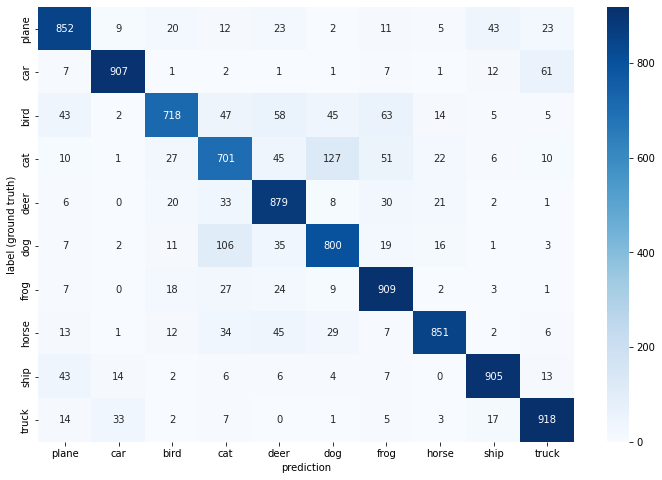

Acc of plane: 0.8520
Acc of car: 0.9070
Acc of bird: 0.7180
Acc of cat: 0.7010
Acc of deer: 0.8790
Acc of dog: 0.8000
Acc of frog: 0.9090
Acc of horse: 0.8510
Acc of ship: 0.9050
Acc of truck: 0.9180

Total Acc: 0.844


In [ ]:
test_model = NiN(num_classes=10)
test_model.to(device)
best_state_dict = torch.load("model_state_dict.ckpt")
test_model.load_state_dict(best_state_dict)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
test(test_model, test_dataloader, class_names)

Reference:
* [Network In Network](https://arxiv.org/pdf/1312.4400.pdf)
* [Dive into Deep Learning - Section 8.3](http://d2l.ai/chapter_convolutional-modern/nin.html)
* [Blog Post from 星期五。見面](https://meetonfriday.com/posts/a151bfa2/)
* [Blog Post from Math.py](https://allen108108.github.io/blog/2019/10/07/%5B%E8%AB%96%E6%96%87%5D%20Network%20In%20Network/)